# Dense Layers: Predicción del valor de vivienda
**Autores:**

A00835733 - Rolando Ruiz Martínez

A01285367 - Natalia Olvera Ortiz

A01425341 - Carol Jatziry Rendón Guerrero

A01571463 - Ericka Sofía Rodríguez Sánchez

A00835576 - Marcos Renato Aquino García  

**Fecha de entrega:** 06/10/2025

## Introducción
Este notebook implementa una red neuronal de capas densas (Dense layers) para predecir el valor mediano de las viviendas usando el dataset California Housing.

El objetivo de este trabajo es:
- Realizar una exploración y preprocesamiento de los datos
- Diseñar y entrenar arquitecturas de redes neuronales densas.
- Justificar las decisiones tomadas en el diseño de la red (arquitectura, optimizador, función de pérdida e inicializadores).
- Comparar modelos utilizando métricas claves como MSE, MAE y R².

In [ ]:
# IMPORTS Y CONFIGURACIÓN INICIAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Herramientas dde Scikit-learn para el manejo y preprocesamiento de datos
from sklearn.datasets import fetch_california_housing # para cargar el dataset
from sklearn.model_selection import train_test_split #para dividir los datos en conjuntos
from sklearn.preprocessing import StandardScaler # para estandarizar los datos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #métricas de evaluación

#Importar Tensorflow y Keras (librerias para deep learning )
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
#Importar capas, inicializadores y callbacks
from tensorflow.keras import layers, initializers, callbacks

# Se fija una semilla para garantizar la reproducibilidad del experimento
# Este paso es importante para asegurar que los resultados sean consistentes entre las ejecucioines
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Exploración, explicación y limpieza de datos

- **Origen:** El conjunto de datos proviene de los datasets ofrecidos por sklearn, este en particular contiene información acerca de viviendas en California. `sklearn.datasets.fetch_california_housing` .
- **Contexto:** El conjunto de datos proviene de un censo realizado en Estados Unidos en los 90s donde cada fila representa a un grupo de bloques. La variable objetivo de este estudio es `MedHouseVal`, la cual contiene el valor medio de las viviendas en California, experesado en cientros de miles de dólares.

In [ ]:
# CARGA DE DATOS Y ANÁLISIS INICIAL

# Se cargan los datos y se convierten en DataFrame de pandas para su fácil manipulación
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()# se crea una copia para asegurar que el originial no se modifique
df.head()# Mueswtra las primeras 5 filas para una inspección rápida

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
# Análisis inicial básico: columnas, tipos, instancias, valores faltantes
print("Columnas:", df.columns.tolist())
print("\nInstancias:", df.shape[0])
print("\nCaracterísticas:", df.shape[1]-1)
print("\nTipos de dato:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isnull().sum())

Columnas: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Instancias: 20640

Características: 8

Tipos de dato:
 MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Valores nulos por columna:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


### Observaciones:
- **Estructura:** El dataset consta de **20,640 instancias** y **8 características numéricas** de tipo `float64`, además del target (`MedHouseVal`).
- **Valores Nulos:** El análisis confirma que **no hay valores nulos** (`NaN`) en ninguna columna, lo que simplifica el proceso de limpieza al no requerir imputación.
- **Necesidad de Escalamiento:** Todas las variables son numéricas, pero al ver las primeras filas se nota que sus rangos varían significativamente (e.g., `MedInc` está entre 0.5 y 15, mientras que `Population` está entre 3 y 35,682).

In [ ]:
# ESTADÍSTICAS DESCRIPTIVAS Y DISTRIBUCIÓN
#Se traspone el resultado (.T) para mejorar la legibilidad y observar la escala, media y desviación estándar de cada feature.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


Al analizar las estadísticas descriptivas se puede observar que el conjunto de datos cuenta con múltiples escalas. Además, se pueden identificar outliars en columnas como `AveRooms`, `AveBedrms` y `AveOccup`, donde los valores máximos están muy alejados del promedio. Así como la estandarización de la escala de las variables, será muy importante el tratamiento de los valores atípicos para evitar sesgos en el modelo. Finalmente, se puede observar que tanto la variable `MedInc` como la viariable objetivo (`MedHouseVal`) cuentan con una dispersión amplia.

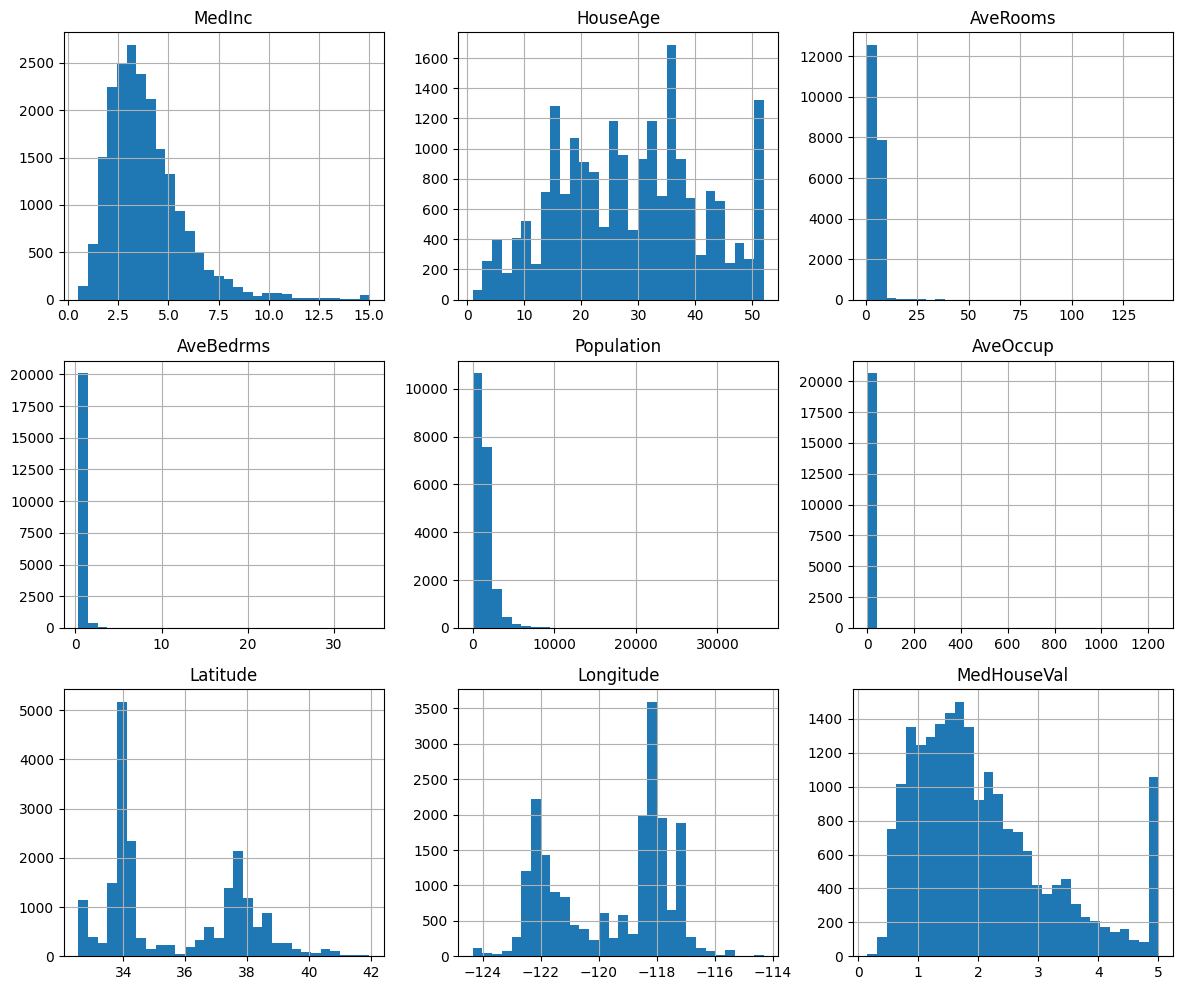

In [ ]:
# VISIALIZACIÓN DE LA DISTRIBUCIÓN DE DATOS
# Se grafican histogramas para visualizar la distribución de cada característica y el target
df.hist(bins=30, figsize=(12,10))
plt.tight_layout()
plt.show()


#### Justificación del Escalamiento (StandardScaler)
La tabla de estadísticas y los histogramas confirman una gran diferencia en las escalas de las variables.
Se utiliza **StandardScaler**, que estandariza las características (media=0, desviación estándar=1). Esto se realiza ya que en el entrenamiento de Redes Neuronales, es fundamental escalar los datos para que el descenso de gradiente (Gradient Descent) funcione de manera eficiente, converja más rápido y evite que características con grandes magnitudes (como `Population`) dominen la función de pérdida.

#### División de Datos (Entrenamiento, Validación y Prueba)
Para garantizar una evaluación imparcial del modelo final y realizar un tuning de hiperparámetros robusto, se dividirá el dataset en tres conjuntos con `random_state=SEED` para reproducibilidad:
* **Entrenamiento (56%):** Usado para ajustar los pesos del modelo.
* **Validación (14%):** Usado para monitorear el rendimiento durante el entrenamiento y aplicar **Early Stopping**.
* **Prueba (30%):** Usado una única vez al final para obtener la métrica de generalización.


In [ ]:
# Separación de Features(X) y target(y)
X = df.drop(columns=['MedHouseVal']).values # todas las columnas excepto la variable objetivo
y = df['MedHouseVal'].values #Solo la variable objetivo

# División inicial: Split train / test (70/30), luego separaremos validación desde train
#se realiza la división inicial con la semilla para reproducibilidad
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED)

# División del resto
# Split train/val (de train_full -> 85/15 ~ 59.5/10.5 total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Incialización y ajuste del scaler
scaler = StandardScaler()

# El scaler solo se ajusta sobre los datos de entrenamiento
# Esto es importante para evitar el "Data leakage" de los conjuntos de validación/prueba
X_train_scaled = scaler.fit_transform(X_train)
# transformación de la estandarización a los conjuntos restantes.
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: (11558, 8) Val: (2890, 8) Test: (6192, 8)


## Desarrollo del Modelo de Deep Learning

Estrategia:
- Modelo base: Se exploraron dos arquitecturas de redes neuronales, la original con dos capas densas `[128,64]` y una más profunda con tres capas densas `[128,128,64]`.

- Inicializadores probados: **GlorotUniform (Xavier)** y **HeNormal**.
- Optimizadores probados: **Adam** (lr=1e-3), SGD con momentum (lr=1e-2, momentum=0.9).
- Función de pérdida: MSE; además registramos MAE (para interpretar errores en unidades de target).
- Regularización: Entre las diversas configuraciones se probaron regularización L2, dropout y early stopping probados.
- Evaluación: MSE, MAE, R² en set de prueba.


El problema de la predicción de precios es una tarea de **regresión**.

#### Justificación de Componentes Clave
* **Función de Activación Oculta:** **ReLU** es regularmente una elección estándar en capas intermedias por su eficiencia computacional y su capacidad para mitigar el problema del gradiente desvaneciente en comparación con Sigmoide o Tanh.
* **Capa de Salida:** Una única neurona (`units=1`) con activación **Lineal** (`activation='linear'`). En problemas de regresión, no se requiere limitar la salida (como en clasificación), por lo que la función lineal es la apropiada.
* **Función de Pérdida (Loss Function):** **Mean Squared Error (MSE)**. Esta función de pérdida utilizada para regresión penaliza más fuertemente los errores grandes (outliers) al elevarlos al cuadrado, optimizando la precisión general.
* **Optimizador:** **Adam** (Adaptive Moment Estimation). Este es robusto y eficiente,adaptando la tasa de aprendizaje para cada peso de la red, garantizando una convergencia rápida.

### Justificación de Inicializaciones de Pesos (He vs. Xavier/Glorot)

La inicialización de pesos es crítica para un entrenamiento efectivo:
* **Inicializador Xavier/Glorot (`glorot_uniform`):** Teóricamente óptimo para funciones de activación centradas en cero, como **Tanh**.
* **Inicializador He (`he_uniform`):** Teóricamente óptimo para funciones de activación que son cero para entradas negativas, como **ReLU**.

**Hipótesis:** Se espera que el **Inicializador He** supere a Xavier en esta arquitectura debido a que se está utilizando **ReLU** en las capas ocultas.

In [ ]:
# Función que crea el modelo (hiperparámetros como argumentos)
def build_model(input_shape, hidden_layers=[64, 64], initializer='glorot_uniform', l2_reg=0.0, dropout_rate=0.0):
    model = keras.Sequential()
    #capas de entrada
    model.add(layers.InputLayer(input_shape=(input_shape,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu',
                               kernel_initializer=initializer,
                               kernel_regularizer=keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer para regresión
    model.add(layers.Dense(1, activation='linear'))
    return model

In [ ]:
# Hiperparámetros iniciales
input_shape = X_train_scaled.shape[1]
base_config = {
    'hidden_layers': [128, 64],
    'initializer': 'glorot_uniform',  # Xavier
    'l2_reg': 1e-5,
    'dropout_rate': 0.0
}

# Compilación y entrenamiento de dos configuraciones para comparar
def compile_and_train(config, optimizer, epochs=50, batch_size=32, verbose=0):
    model = build_model(input_shape=input_shape, **config)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val_scaled, y_val), callbacks=[es], verbose=verbose)
    return model, history

# Prueba A: Xavier + Adam
opt_adam_A = keras.optimizers.Adam(learning_rate=1e-3)
model_A, history_A = compile_and_train(base_config, opt_adam_A, epochs=50, verbose=1)

# Prueba B: He + Adam (He es apropiado con ReLU)
config_B = base_config.copy()
config_B['initializer'] = 'he_normal'
opt_adam_B = keras.optimizers.Adam(learning_rate=1e-3)  # NEW optimizer
model_B, history_B = compile_and_train(config_B, opt_adam_B, epochs=50, verbose=1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 1.2702 - mae: 0.7872 - val_loss: 0.6005 - val_mae: 0.4747
Epoch 2/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 0.4044 - mae: 0.4468 - val_loss: 0.4275 - val_mae: 0.4449
Epoch 3/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 0.3675 - mae: 0.4282 - val_loss: 0.3821 - val_mae: 0.4284
Epoch 4/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 0.3506 - mae: 0.4167 - val_loss: 0.3796 - val_mae: 0.4175
Epoch 5/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 0.3370 - mae: 0.4067 - val_loss: 0.3932 - val_mae: 0.4081
Epoch 6/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.3272 - mae: 0.3994 - val_loss: 0.3538 - val_mae: 0.4004
Epoch 7/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 0.3192 - mae: 0.3940 - val_loss: 0.3440 - val_mae: 0.3959
Epoch 8/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.3135 - mae: 0.3894 - val_loss: 0.3382 - val_mae: 0.3904
Epoch 9/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/st

In [ ]:
# Función para crear un modelo con arquitectura diferente
def build_model_new_arch(input_shape, hidden_layers, initializer, l2_reg=0.0, dropout_rate=0.0):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(input_shape,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu',
                               kernel_initializer=initializer,
                               kernel_regularizer=keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='linear'))
    return model

# Definir los nuevos hiperparametros de las dos configuraciones
new_input_shape = X_train_scaled.shape[1]

config_C = {
    'hidden_layers': [128, 128, 64],
    'initializer': 'he_normal',
    'l2_reg': 1e-4,
    'dropout_rate': 0.2
}

config_D = {
    'hidden_layers': [128, 128, 64],
    'initializer': 'glorot_uniform',
    'l2_reg': 0.0,
    'dropout_rate': 0.0
}


def compile_and_train_new(config, optimizer, epochs=50, batch_size=64, verbose=1):
    model = build_model_new_arch(input_shape=new_input_shape, **config)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val_scaled, y_val), callbacks=[es], verbose=verbose)
    return model, history

# Prueba C: He + Adam with regularization
opt_adam_C = keras.optimizers.Adam(learning_rate=1e-3)
model_C, history_C = compile_and_train_new(config_C, opt_adam_C, epochs=50, verbose=1)

# Prueba D: Xavier + SGD with momentum, no regularization
opt_sgd_D = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model_D, history_D = compile_and_train_new(config_D, opt_sgd_D, epochs=50, verbose=1)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - loss: 2.5428 - mae: 1.0418 - val_loss: 1.3538 - val_mae: 0.6563
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 1.0793 - mae: 0.7018 - val_loss: 1.6221 - val_mae: 0.6363
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.8992 - mae: 0.6463 - val_loss: 5.5960 - val_mae: 0.6145
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.8486 - mae: 0.6078 - val_loss: 0.8893 - val_mae: 0.5783
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.7184 - mae: 0.5792 - val_loss: 0.7097 - val_mae: 0.5125
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 0.6568 - mae: 0.5470 - val_loss: 0.7289 - val_mae: 0.4802
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.6226 - mae: 0.5300 - val_loss: 0.5554 - val_mae: 0.4759
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.5775 - mae: 0.5126 - val_loss: 0.6127 - val_mae: 0.4624
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 

Para evaluar el desempeño de los 4 modelos y visualizar el historial de entrenamiento se definieron las funciones `plot_history` y `evaluate_model`.

In [ ]:
# Función para graficar historial
def plot_history(histories, titles):
    plt.figure(figsize=(12,5))
    for history, title in zip(histories, titles):
        plt.plot(history.history['val_loss'], label=f'{title} val_loss')
        plt.plot(history.history['loss'], '--', label=f'{title} train_loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Historial de entrenamiento (MSE)')
    plt.show()

In [ ]:
# Función para evaluar en el set de test las configuraciones
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test).ravel()
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {'mse': mse, 'mae': mae, 'r2': r2, 'preds': preds}

## Resultados e Interpretación

A continuación mostramos estas comparaciones.

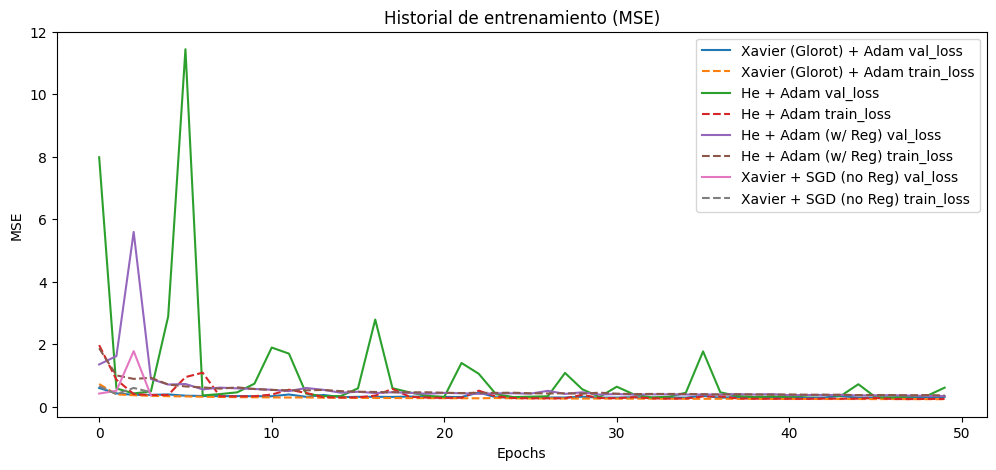

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
 25/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
 18/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
 21/194 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
                   config       MSE       MAE        R2
0  Xavier (Glorot) + Adam  0.283437  0.361732  0.784055
1               He + Adam  0.299301  0.372716  0.771968
2      He + Adam (w/ Reg)  0.287471  0.365983  0.780981
3   Xavier + SGD (no Reg)  0.351494  0.418351  0.732203


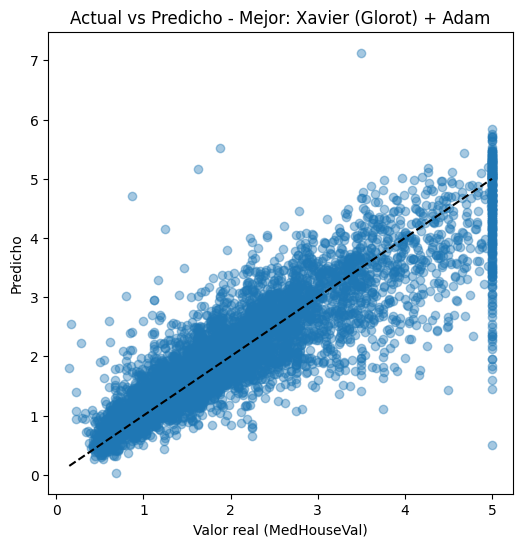

In [ ]:
# Evaluación y presentación de resultados
histories = [history_A, history_B, history_C, history_D]
titles = ['Xavier (Glorot) + Adam', 'He + Adam', 'He + Adam (w/ Reg)', 'Xavier + SGD (no Reg)']
plot_history(histories, titles)

results = {
    'A': evaluate_model(model_A, X_test_scaled, y_test),
    'B': evaluate_model(model_B, X_test_scaled, y_test),
    'C': evaluate_model(model_C, X_test_scaled, y_test),
    'D': evaluate_model(model_D, X_test_scaled, y_test)
}

summary = pd.DataFrame({
    'config': titles,
    'MSE': [results['A']['mse'], results['B']['mse'], results['C']['mse'], results['D']['mse']],
    'MAE': [results['A']['mae'], results['B']['mae'], results['C']['mae'], results['D']['mae']],
    'R2': [results['A']['r2'], results['B']['r2'], results['C']['r2'], results['D']['r2']]
})
print(summary)

best_mae = float('inf')
best_model_name = ''
for name, res in results.items():
    if res['mae'] < best_mae:
        best_mae = res['mae']
        best_model_name = name

best_model_preds = results[best_model_name]['preds']
best_model_title = summary[summary['config'].str.contains(best_model_name)]['config'].values[0]

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_model_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Valor real (MedHouseVal)')
plt.ylabel('Predicho')
plt.title(f'Actual vs Predicho - Mejor: {best_model_title}')
plt.show()


### Interpretación

Tras entrenar y evaluar los cuatro modelos, se identificaron diferencias en su desempeño y eficiencia.

El **Modelo A (Xavier + Adam)** se destacó por lograr el MAE más bajo (0.3617) y el R^2 más alto (0.7841). Su arquitectura de dos capas densas es más simple que la arquitectura con tres capas. Esto sugiere que para este conjunto de datos no se requiere una complejidad muy elevada para lograr un buen desempeño.

Algo interesante fue que el **Modelo B (He + Adam)** tuvo un desempeño ligeramente menor al del Modelo A, a pesar de que el inicializador He es el recomendado para ReLU.

A pesar de que en el **Modelo C (He + Adam c/Reg)** también se tuvo un buen desempeño y se observó que la regularización ayudó a evitar el sobreajuste, no se observó una mejora significativa que justificara su complejidad.

Finalmente, el **Modelo D (Xavier + SGD no Reg)** mostró el peor rendimiento, lo que resaltó la superioridad de Adam para este caso en específico.

En resumen, el **Modelo A** fue la mejor alternativa para este caso.

## Conclusión
El análisis demostró que en ocasiones arquitecturas más simples con una buena selección de hiperparámetros pueden superar el desempeño de arquitecturas más complejas. El **Modelo A** fue el que mostró el mejor rendimiento y la gráfica de dispersión muestra que el problema del modelo es mayormente para predecir con precisión los valores de vivienda más altos.